# import the pretrained images annotation

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="xXQox5wqZetv3gM7zlGz")
project = rf.workspace("dataset-xd7q9").project("dogs-and-cats1")
version = project.version(1)
dataset = version.download("yolov8")                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dogs-and-Cats1-1 in yolov8:: 100%|██████████| 1012/1012 [00:00<00:00, 2114.23it/s]


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="Vr3Sk6Wt5egVvPu7AnQk")
project = rf.workspace("cato-dbqi8").project("cato-nlzec")
version = project.version(1)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cato-1 in yolov8:: 100%|██████████| 972/972 [00:00<00:00, 2106.24it/s]


# Merge the two pretrained images in one folder

In [ ]:
import os
import shutil
import yaml


dataset1_folder = "C:/Users/Miggy/Documents/Applied Data Science with Python/Object Detection Final/Cato-1"
dataset2_folder = "C:/Users/Miggy/Documents/Applied Data Science with Python/Object Detection Final/Dogs-and-Cats1-1"


merged_dataset_folder = 'merged-cat-dog-dataset'

def merge_yolo_datasets(dataset1_path, dataset2_path, merged_path):
    """
    Merges two YOLOv8 datasets, specifically handling the consolidation of
    'Cat', 'Cats', and 'Dogs' into 'cat' and 'dog'.
    """
    print("Starting custom dataset merge...")

    os.makedirs(os.path.join(merged_path, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(merged_path, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(merged_path, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(merged_path, 'labels/val'), exist_ok=True)

    final_class_names = ['cat', 'dog']
    print(f"Final, unified class names will be: {final_class_names}")

    with open(os.path.join(dataset1_path, 'data.yaml')) as f:
        yaml1 = yaml.safe_load(f)
    with open(os.path.join(dataset2_path, 'data.yaml')) as f:
        yaml2 = yaml.safe_load(f)
    print(f"Original names in Dataset 1: {yaml1['names']}")
    print(f"Original names in Dataset 2: {yaml2['names']}")

    name_to_final_id = {
        'Cat': 0, 'Cats': 0, # Both map to 'cat'
        'Dogs': 1, 'Dog': 1, 'dog': 1, 'cat': 0 # Add variations just in case
    }
    map1 = {i: name_to_final_id[name] for i, name in enumerate(yaml1['names']) if name in name_to_final_id}
    map2 = {i: name_to_final_id[name] for i, name in enumerate(yaml2['names']) if name in name_to_final_id}
    print(f"Mapping for Dataset 1: {map1}")
    print(f"Mapping for Dataset 2: {map2}")

    merged_yaml_data = {
        'train': '../images/train',
        'val': '../images/val',
        'nc': len(final_class_names), 
        'names': final_class_names
    }
    with open(os.path.join(merged_path, 'data.yaml'), 'w') as f:
        yaml.dump(merged_yaml_data, f, sort_keys=False)
        print("\nCreated new 'data.yaml' with nc=2.")

    def process_split(split, dataset_path, class_map):
        image_source_dir = os.path.join(dataset_path, f'{split}/images')
        label_source_dir = os.path.join(dataset_path, f'{split}/labels')
        if not os.path.exists(image_source_dir):
            return
        for filename in os.listdir(image_source_dir):
            base, ext = os.path.splitext(filename)
            label_filename = f"{base}.txt"
            old_label_path = os.path.join(label_source_dir, label_filename)
            if os.path.exists(old_label_path):
                shutil.copy2(os.path.join(image_source_dir, filename), 
                             os.path.join(merged_path, f'images/{split}'))
                new_label_path = os.path.join(merged_path, f'labels/{split}', label_filename)
                with open(old_label_path, 'r') as f_in, open(new_label_path, 'w') as f_out:
                    for line in f_in:
                        try:
                            parts = line.strip().split()
                            old_cls_id = int(parts[0])
                            if old_cls_id in class_map:
                                new_cls_id = class_map[old_cls_id]
                                new_line = f"{new_cls_id} {' '.join(parts[1:])}\n"
                                f_out.write(new_line)
                        except (ValueError, IndexError):
                            continue 
    print("\nProcessing Dataset 1...")
    process_split('train', dataset1_path, map1)
    process_split('val', dataset1_path, map1)

    print("\nProcessing Dataset 2...")
    process_split('train', dataset2_path, map2)
    process_split('val', dataset2_path, map2)

    print(f"\nMerge complete! New dataset created at: {merged_path}")


if __name__ == "__main__":
    merge_yolo_datasets(dataset1_folder, dataset2_folder, merged_dataset_folder)

Starting custom dataset merge...
Final, unified class names will be: ['cat', 'dog']
Original names in Dataset 1: ['Cat', 'Cats']
Original names in Dataset 2: ['Dogs']
Mapping for Dataset 1: {0: 0, 1: 0}
Mapping for Dataset 2: {0: 1}

Created new 'data.yaml' with nc=2.

Processing Dataset 1...

Processing Dataset 2...

Merge complete! New dataset created at: merged-cat-dog-dataset


# Train the model

In [12]:
from ultralytics import YOLO

dataset_yaml_path = 'merged-cat-dog-dataset/data.yaml'

model = YOLO('yolov8s.pt')

In [ ]:
results = model.train(
    data=dataset_yaml_path,
    epochs=100,      
    imgsz=640,       
    batch=8,         
    name='cat_dog_merged_v1' 
)

print("\n--- TRAINING COMPLETE! ---")
print("Your new custom model has been saved.")
print("The best performing version is located in the folder:")
print(f"runs/detect/{results.save_dir.name}/weights/best.pt")


Ultralytics 8.3.159  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=merged-cat-dog-dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cat_dog_merged_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

train: Scanning C:\Users\Miggy\Documents\Applied Data Science with Python\Object Detection Final\merged-cat-dog-dataset\labels\train... 496 images, 24 backgrounds, 0 corrupt: 100%|██████████| 496/496 [00:00<00:00, 1531.72it/s]

train: New cache created: C:\Users\Miggy\Documents\Applied Data Science with Python\Object Detection Final\merged-cat-dog-dataset\labels\train.cache


val: Fast image access  (ping: 0.00.0 ms, read: 187.752.4 MB/s, size: 47.5 KB)


val: Scanning C:\Users\Miggy\Documents\Applied Data Science with Python\Object Detection Final\merged-cat-dog-dataset\labels\val... 190 images, 9 backgrounds, 0 corrupt: 100%|██████████| 190/190 [00:00<00:00, 992.78it/s]

val: New cache created: C:\Users\Miggy\Documents\Applied Data Science with Python\Object Detection Final\merged-cat-dog-dataset\labels\val.cache


Plotting labels to runs\detect\cat_dog_merged_v1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\cat_dog_merged_v1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         2G     0.9645      1.968      1.545         15        640: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.61it/s]

                   all        190        190      0.124       0.27      0.108     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.24G       1.14      1.632       1.67         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.23it/s]

                   all        190        190      0.282       0.51      0.261     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.24G      1.272      1.663      1.768         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.34it/s]

                   all        190        190      0.452      0.615      0.431      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.24G      1.256      1.629      1.735         24        640: 100%|██████████| 62/62 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.26it/s]

                   all        190        190      0.219      0.546       0.22     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.24G      1.261      1.631      1.758         27        640: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.07it/s]

                   all        190        190      0.255      0.399      0.229     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.24G      1.268      1.592      1.746         30        640: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.25it/s]

                   all        190        190      0.516      0.716      0.609      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.24G      1.204      1.564      1.704         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]

                   all        190        190      0.529      0.644      0.546      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.24G      1.126      1.494      1.653         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.97it/s]

                   all        190        190      0.476      0.516      0.431       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.24G      1.105      1.464      1.626         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.12it/s]

                   all        190        190      0.383      0.566      0.429      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.24G      1.119      1.487      1.631         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.20it/s]

                   all        190        190      0.404      0.748      0.511      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.24G      1.177       1.43      1.706         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]

                   all        190        190      0.189      0.287      0.184     0.0476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.24G      1.091      1.397      1.631         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.33it/s]

                   all        190        190      0.555      0.613       0.58      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.24G      1.073      1.379       1.62         14        640: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.44it/s]

                   all        190        190      0.591      0.572      0.574      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.24G      1.096      1.357      1.617         27        640: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.19it/s]

                   all        190        190      0.466      0.382      0.394      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.24G      1.045      1.349      1.584         24        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.34it/s]

                   all        190        190      0.594      0.748      0.648      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.24G      1.055      1.312      1.581         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.40it/s]

                   all        190        190      0.683      0.666      0.665      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.24G      0.997      1.325      1.542         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.34it/s]

                   all        190        190       0.48      0.664      0.638      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.24G      1.029      1.267      1.573         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.02it/s]

                   all        190        190      0.744      0.671      0.747      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.24G      1.047      1.246      1.573         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.33it/s]

                   all        190        190      0.666      0.694       0.67        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.24G     0.9761      1.219      1.518         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.91it/s]

                   all        190        190       0.68      0.701      0.739      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.24G     0.9398      1.191      1.506         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.32it/s]

                   all        190        190      0.632      0.739      0.676      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.24G     0.9718      1.223      1.525         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.40it/s]

                   all        190        190      0.703      0.664      0.692      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.24G     0.9121      1.192      1.476         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.698      0.709      0.725      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.24G     0.9236      1.171      1.486         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.28it/s]

                   all        190        190      0.747        0.7       0.74      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.24G     0.9304      1.191      1.501         18        640: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.24it/s]

                   all        190        190      0.612      0.694      0.717      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.24G     0.8849      1.124      1.451         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.689      0.697      0.716      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.24G     0.9104      1.128      1.468         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.23it/s]

                   all        190        190      0.732      0.732      0.753      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.24G     0.8948      1.089      1.461         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.26it/s]

                   all        190        190      0.807      0.813      0.835      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.24G     0.8938      1.089      1.451         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.22it/s]

                   all        190        190      0.672      0.765      0.758      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.24G     0.9205      1.149      1.491         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.29it/s]

                   all        190        190       0.72      0.783      0.768       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.24G     0.8815      1.091      1.429         25        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.38it/s]

                   all        190        190      0.817      0.766      0.815      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.24G     0.8545      1.045      1.429         14        640: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.30it/s]

                   all        190        190      0.788      0.791       0.83      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.24G     0.8458      1.132      1.447         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.25it/s]

                   all        190        190      0.763      0.751        0.8       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.24G     0.8383      1.032      1.421         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.25it/s]

                   all        190        190      0.763      0.748      0.812      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.24G     0.8459      1.068      1.415         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.45it/s]

                   all        190        190      0.771      0.745      0.799      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.24G     0.8361      1.054      1.404         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.34it/s]

                   all        190        190      0.784      0.802      0.835      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.24G     0.8024      1.009      1.396         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.41it/s]

                   all        190        190      0.753      0.814      0.827       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.24G     0.8197      1.047      1.412         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.29it/s]

                   all        190        190      0.819      0.799      0.844      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.24G     0.8418       1.04      1.429         24        640: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.41it/s]

                   all        190        190      0.754      0.822      0.808      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.24G     0.7809     0.9613      1.383         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.15it/s]

                   all        190        190      0.848      0.764      0.855      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.24G     0.8004      1.016      1.392         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.36it/s]

                   all        190        190       0.75      0.769      0.819      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.24G      0.807      1.022      1.382         17        640: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.20it/s]

                   all        190        190      0.744      0.821      0.841      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.24G      0.807      1.004        1.4         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.49it/s]

                   all        190        190      0.825      0.807      0.835      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.24G     0.8171      1.034      1.405         25        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.07it/s]

                   all        190        190      0.771      0.772      0.802      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.24G      0.767     0.9544      1.363         25        640: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.41it/s]

                   all        190        190      0.843      0.775      0.851      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.24G      0.805      1.002      1.394         14        640: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.14it/s]

                   all        190        190        0.8      0.842      0.859      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.24G     0.7994     0.9753      1.411         16        640: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.13it/s]

                   all        190        190      0.825      0.794      0.837      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.24G     0.7406     0.9339      1.343         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.13it/s]

                   all        190        190      0.765      0.808      0.836      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.24G     0.7166     0.9279      1.329         13        640: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.24it/s]

                   all        190        190      0.816      0.791       0.85      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.24G     0.7324     0.9486      1.318         27        640: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]

                   all        190        190       0.76      0.785      0.815      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.24G      0.697     0.9081      1.313         27        640: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

                   all        190        190      0.782      0.862      0.856      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.24G     0.7331       0.91      1.342         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

                   all        190        190      0.773      0.753      0.793      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.24G      0.728     0.8709      1.326         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        190        190      0.839      0.779       0.85      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.24G     0.7339     0.8793      1.347         17        640: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.19it/s]

                   all        190        190      0.831      0.817       0.88      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.24G      0.731     0.8801      1.342         24        640: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.31it/s]

                   all        190        190       0.79      0.788      0.829      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.24G      0.715     0.9051      1.322         22        640: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]

                   all        190        190      0.783      0.824      0.851       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.24G     0.6821     0.8476      1.306         18        640: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.48it/s]

                   all        190        190      0.776      0.786      0.829        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.24G     0.6932     0.8441      1.298         18        640: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]

                   all        190        190      0.743      0.807      0.843      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.24G     0.6797     0.8496      1.289         16        640: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.42it/s]

                   all        190        190      0.776      0.865      0.878      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.24G     0.6936     0.8584      1.295         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]

                   all        190        190      0.782      0.832      0.873      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.24G     0.6345     0.8116      1.263         25        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.29it/s]

                   all        190        190      0.827      0.807      0.846      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.24G     0.6625     0.8109      1.277         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]

                   all        190        190      0.785      0.809      0.834      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.24G     0.6586     0.8114      1.287         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

                   all        190        190      0.742      0.849      0.854      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.24G     0.6378     0.7854      1.277         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.49it/s]

                   all        190        190      0.765      0.844      0.835      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.24G      0.667      0.814      1.286         25        640: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.36it/s]

                   all        190        190      0.848      0.813      0.851      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.24G     0.6509     0.8077      1.267         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.36it/s]

                   all        190        190      0.767      0.849      0.863      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.24G      0.673     0.8117      1.287         18        640: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.42it/s]

                   all        190        190      0.825      0.847      0.868      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.24G     0.6085      0.758      1.248         12        640: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.776      0.839      0.845       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.24G     0.6094     0.7433      1.257         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.41it/s]

                   all        190        190      0.793      0.824      0.866      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.24G     0.6243     0.7558      1.256         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.857      0.869      0.891      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.24G     0.6344      0.746      1.251         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.28it/s]

                   all        190        190       0.84      0.831      0.885       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.24G     0.5874     0.7459      1.219         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.26it/s]

                   all        190        190      0.842       0.82      0.895       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.24G     0.6015     0.7548      1.241         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

                   all        190        190      0.816      0.873       0.89      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.24G     0.6047     0.6961       1.23         16        640: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.16it/s]

                   all        190        190      0.746      0.831      0.852      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.24G     0.6354     0.7868      1.249         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

                   all        190        190      0.845      0.868      0.881      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.24G     0.5943     0.7169      1.222         24        640: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.24it/s]

                   all        190        190      0.802      0.837      0.849      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.24G      0.592     0.7125      1.237         20        640: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.53it/s]

                   all        190        190      0.834      0.819      0.865      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.24G     0.5844     0.7095      1.209         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.33it/s]

                   all        190        190      0.804      0.859      0.891      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.24G     0.5753     0.7115       1.22         19        640: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.33it/s]

                   all        190        190      0.841      0.785      0.867      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.24G     0.5615     0.6936      1.205         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.858      0.859      0.898      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.24G     0.5724     0.6743      1.219         17        640: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.33it/s]

                   all        190        190       0.87      0.869      0.919       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.24G     0.5645     0.6839      1.203         27        640: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.20it/s]

                   all        190        190      0.878      0.846      0.911      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.24G     0.5641     0.6823      1.204         26        640: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.825      0.876      0.906      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.24G     0.5411     0.6456      1.185         24        640: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.13it/s]

                   all        190        190      0.878      0.833      0.898      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.24G     0.5429     0.6487      1.191         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.15it/s]

                   all        190        190       0.85       0.84      0.891      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.24G     0.5325     0.6484      1.192         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]

                   all        190        190      0.834      0.886      0.895      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.24G     0.5529      0.648      1.201         23        640: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.831      0.851      0.884      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.24G     0.5417     0.6453      1.189         21        640: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]

                   all        190        190       0.84      0.873      0.893      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.24G     0.5346     0.6428      1.178         13        640: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.22it/s]

                   all        190        190       0.85      0.866      0.893      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.24G     0.5437     0.6478      1.196         28        640: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.06it/s]

                   all        190        190      0.858      0.836      0.894      0.679


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.24G     0.4178     0.4883      1.172          7        640: 100%|██████████| 62/62 [00:09<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.04it/s]

                   all        190        190       0.86      0.851      0.884      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.24G     0.3809     0.4302      1.137          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.20it/s]

                   all        190        190      0.852      0.852       0.88       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.24G      0.355     0.4315      1.136          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.42it/s]

                   all        190        190      0.829      0.891      0.894      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.24G     0.3501     0.4026      1.103          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.42it/s]

                   all        190        190      0.839      0.838      0.882       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.24G     0.3353     0.3769       1.09          9        640: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.34it/s]

                   all        190        190      0.838      0.859      0.899        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.24G     0.3396     0.3669      1.081          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.39it/s]

                   all        190        190      0.844      0.845      0.907      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.24G     0.3229     0.3787      1.104          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.39it/s]

                   all        190        190       0.83      0.866      0.905      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.24G     0.3259     0.3551      1.074          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

                   all        190        190       0.86      0.849      0.897      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.24G     0.3165     0.3399      1.066          7        640: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

                   all        190        190      0.873      0.838      0.907        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.24G     0.2895     0.3345      1.047          8        640: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]

                   all        190        190      0.852      0.843      0.901      0.702



100 epochs completed in 0.305 hours.
Optimizer stripped from runs\detect\cat_dog_merged_v1\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\cat_dog_merged_v1\weights\best.pt, 22.5MB

Validating runs\detect\cat_dog_merged_v1\weights\best.pt...
Ultralytics 8.3.159  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]


                   all        190        190      0.844      0.845      0.907       0.71
                   cat         95        100      0.828       0.79      0.898      0.697
                   dog         86         90      0.861        0.9      0.915      0.722
Speed: 0.4ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\cat_dog_merged_v1

--- TRAINING COMPLETE! ---
Your new custom model has been saved.
The best performing version is located in the folder:
runs/detect/cat_dog_merged_v1/weights/best.pt


# Display the graphs

In [18]:
%matplotlib inline

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

training_run_path = 'runs/detect/cat_dog_merged_v1/'
csv_path = f'{training_run_path}/results.csv'

try:
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip() #
    print("Successfully loaded training data. Here are the first 5 rows:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: Could not find results.csv at '{csv_path}'")
    print("Please make sure the path is correct and the training has completed.")


Successfully loaded training data. Here are the first 5 rows:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,12.8766,0.96455,1.96808,1.54458,0.12393,0.27034,0.10775,0.03856,2.19568,2.62045,2.94137,0.000547,0.000547,0.000547
1,2,23.8346,1.14015,1.63204,1.67018,0.28240,0.51010,0.26129,0.07885,2.23845,3.52211,3.43407,0.001091,0.001091,0.001091
2,3,34.5653,1.27228,1.66277,1.76772,0.45160,0.61496,0.43136,0.20516,1.70039,2.53999,3.04582,0.001625,0.001625,0.001625
3,4,44.9896,1.25596,1.62949,1.73468,0.21891,0.54611,0.22025,0.07930,2.00943,2.36222,2.94269,0.001617,0.001617,0.001617
4,5,55.4105,1.26144,1.63093,1.75770,0.25527,0.39852,0.22927,0.06275,2.60219,2.48669,3.33796,0.001601,0.001601,0.001601



--- Plotting Accuracy (mAP) ---


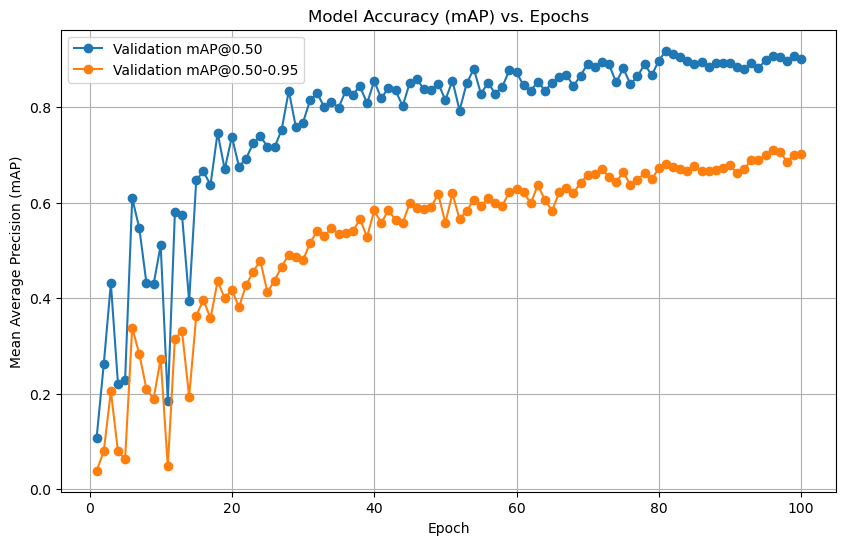

In [20]:
print("\n--- Plotting Accuracy (mAP) ---")
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='Validation mAP@0.50', marker='o')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='Validation mAP@0.50-0.95', marker='o')
plt.title('Model Accuracy (mAP) vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Average Precision (mAP)')
plt.legend()
plt.grid(True)
plt.show()


The model shows robust learning, with the major accuracy parameter (mAP0.50, blue line) continuously growing to an impressive peak of roughly 91%.  The learning process appears stable after epoch 80, indicating that the model has successfully converged on a high-performance solution.


--- Plotting Training and Validation Loss ---


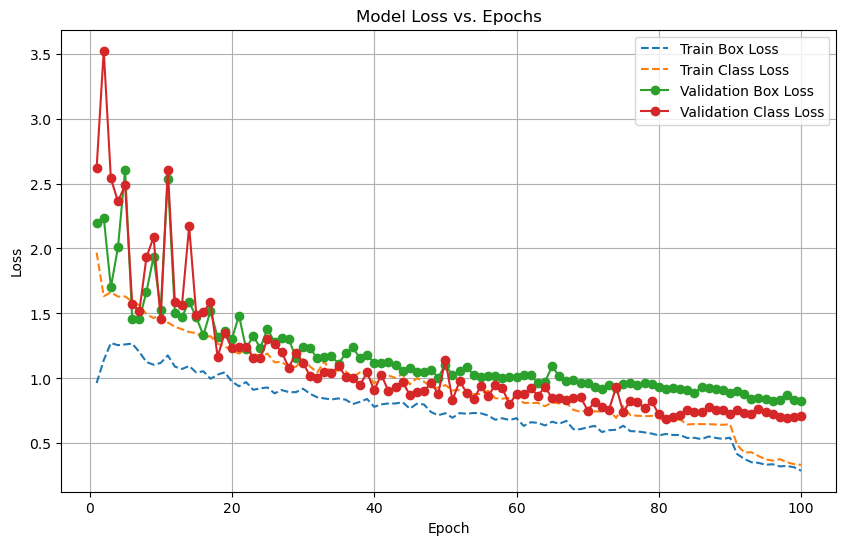

In [21]:
print("\n--- Plotting Training and Validation Loss ---")
plt.figure(figsize=(10, 6))
# Plot training losses
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='--')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='--')
# Plot validation losses
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss', marker='o')
plt.plot(df['epoch'], df['val/cls_loss'], label='Validation Class Loss', marker='o')
plt.title('Model Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The model's loss curves demonstrate good training, since both training (dashed lines) and validation (solid lines) losses continuously decrease across 100 epochs.  The validation loss closely tracks the training loss without diverging, implying that the model generalizes effectively and is not considerably overfitting to the training dataset.

# Conclusion

This project successfully generated a high-performance cat and dog detector by fine-tuning a YOLOv8 model on a custom-merged dataset, with a final accuracy of more than 90% mAP.  The resulting model was implemented in two functional applications: a real-time camera feed and an interactive image uploader, exhibiting a comprehensive and effective end-to-end computer vision pipeline.

# Test the model

In [ ]:
import cv2
from ultralytics import YOLO

model_path = 'runs/detect/cat_dog_merged_v1/weights/best.pt' 

try:
    model = YOLO(model_path)
    print(f"Successfully loaded your custom model from: {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure the model_path is correct and points to your 'best.pt' file.")
    raise SystemExit()

colors = {
    'cat': (0, 255, 0),   
    'dog': (255, 0, 0)     
}
default_color = (0, 0, 255) 


cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("[ERROR] Could not open camera.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame. Exiting.")
            break
        results = model(frame, stream=True)

        for r in results:
            boxes = r.boxes
            for box in boxes:
                confidence = box.conf[0]
                if confidence > 0.5:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    cls = int(box.cls[0])
                    class_name = model.names[cls]
                    color = colors.get(class_name, default_color)
                    label = f'{class_name} {confidence:.2f}'
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        cv2.imshow("Custom Cat & Dog Detector (Press 'q' to quit)", frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()
    print("Detection stopped and resources released.")

Successfully loaded your custom model from: runs/detect/cat_dog_merged_v1/weights/best.pt

0: 480x640 1 dog, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 32.5ms
Speed: 1.7ms preprocess, 32.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 38.3ms
Speed: 2.2ms preprocess, 38.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 37.7ms
Speed: 2.1ms preprocess, 37.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 37.8ms
Speed: 2.1ms preprocess, 37.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 37.9ms
Speed: 2.5ms preprocess, 37.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 38.4ms
Speed: 1.8ms preprocess

### A cat detected in the camera

![A cat detected in camera](test_images/1.png)

### A dog detected in the camera

![A dog detected in camera](test_images/2.png)

# Test using upload images if the model does actually work

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
from PIL import Image as PILImage
import io

model_path = 'runs/detect/cat_dog_merged_v1/weights/best.pt' 

try:
    model = YOLO(model_path)
    print("Successfully loaded custom model.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise SystemExit()

colors = {'cat': (0, 255, 0), 'dog': (255, 0, 0)} 
default_color = (0, 0, 255) 

main_out = widgets.Output()

def run_detector(change):
    """This function is triggered when a file is uploaded."""

    uploaded_file_dict = change['new']
    if not uploaded_file_dict:
        return
        
    file_info = list(uploaded_file_dict.values())[0]
    image_bytes = file_info['content']
    main_out.clear_output()
    with main_out:
        print("Processing image...")
    pil_image = PILImage.open(io.BytesIO(image_bytes))
    frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    results = model(frame)

    for r in results:
        boxes = r.boxes
        for box in boxes:
            confidence = box.conf[0]
            if confidence > 0.5:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cls = int(box.cls[0])
                class_name = model.names[cls]
                color = colors.get(class_name, default_color)
                label = f'{class_name} {confidence:.2f}'
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    _, buffer = cv2.imencode('.jpg', frame)
    main_out.clear_output()
    with main_out:
        display(Image(data=buffer.tobytes()))
        create_uploader()


def create_uploader():
    """This function creates a fresh uploader widget and links it."""
    uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload New Image' 
    )
    uploader.observe(run_detector, names='value')
    with main_out:
        display(uploader)


print("Ready to test your model. Please upload an image.")
main_out.clear_output()
create_uploader()
display(main_out)

Successfully loaded custom model.
Ready to test your model. Please upload an image.


Output()

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
from PIL import Image as PILImage
import io

model_path = 'runs/detect/cat_dog_merged_v1/weights/best.pt' 

try:
    model = YOLO(model_path)
    print("Successfully loaded custom model.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise SystemExit()

colors = {'cat': (0, 255, 0), 'dog': (255, 0, 0)} 
default_color = (0, 0, 255) 

main_out = widgets.Output()

def run_detector(change):
    """This function is triggered when a file is uploaded."""

    uploaded_file_dict = change['new']
    if not uploaded_file_dict:
        return
        
    file_info = list(uploaded_file_dict.values())[0]
    image_bytes = file_info['content']
    main_out.clear_output()
    with main_out:
        print("Processing image...")
    pil_image = PILImage.open(io.BytesIO(image_bytes))
    frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    results = model(frame)

    for r in results:
        boxes = r.boxes
        for box in boxes:
            confidence = box.conf[0]
            if confidence > 0.5:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cls = int(box.cls[0])
                class_name = model.names[cls]
                color = colors.get(class_name, default_color)
                label = f'{class_name} {confidence:.2f}'
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    _, buffer = cv2.imencode('.jpg', frame)
    main_out.clear_output()
    with main_out:
        display(Image(data=buffer.tobytes()))
        create_uploader()


def create_uploader():
    """This function creates a fresh uploader widget and links it."""
    uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload New Image' 
    )
    uploader.observe(run_detector, names='value')
    with main_out:
        display(uploader)


print("Ready to test your model. Please upload an image.")
main_out.clear_output()
create_uploader()
display(main_out)

Successfully loaded custom model.
Ready to test your model. Please upload an image.


Output()